# Study of the best MVA1 & MVA2 cut with $Z^0 \rightarrow b\bar{b}$ and $B^+ \rightarrow \tau^+ \nu_\tau$ background

In [1]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
bc_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bu_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
tree_gen = uproot.open("/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [3]:
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
df_gen = tree_gen.arrays(library="pd", how="zip")

#### Parameters

In [4]:
N_Z0 = 5*10**(12)
BF_Zbb = 0.1512
f_Bc = 0.0004
f_Bu = 0.43
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

In [5]:
total_nb_gen = df_gen.iloc[0]["eventsProcessed"]

nb_signal_events = len(bc_df['EVT_MVA1'])
#nb_signal_events2 = len(bc_df['EVT_MVA2'])
nb_bkg_events1 = len(bu_df['EVT_MVA2'])
nb_bkg_events2 = len(bb_df['EVT_MVA2'])

initial_eff_signal = nb_signal_events/total_nb_gen
#initial_eff_signal2 = nb_signal_events1/total_nb_gen
initial_eff_bkg = nb_bkg_events1/total_nb_gen
initial_eff_incl_bkg = nb_bkg_events2/total_nb_gen

In [6]:
def S_cut(cut_eff) :
    return N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion*initial_eff_signal*cut_eff
def B_cut(cut_eff) :
    return N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion*initial_eff_bkg*cut_eff
def B_incl_cut(cut_eff) :
    return N_Z0*BF_Zbb*2*initial_eff_incl_bkg*cut_eff

cut_step = 0.00005
cut_value1 = 0.99
cut_value2 = 0.99
var1 = 'EVT_MVA1'
var2 = 'EVT_MVA2'

#max_cut_value = max(bc_df[var].max(), bb_df[var].max())
max_cut_value1 = min(bb_df[var1].max(),bu_df[var1].max())
max_cut_value2 = min(bb_df[var2].max(),bu_df[var2].max())

l_cut1 = []
l_cut2 = []
l_s = []
l_b = []
l_p = []

while (cut_value1 < max_cut_value1) :
    
    while (cut_value2 < max_cut_value2) :

        df_signal = bc_df[(bc_df[var1] > cut_value1)&(bc_df[var2] > cut_value2)]
        df_bkg1 = bb_df[(bu_df[var1] > cut_value1)&(bu_df[var2] > cut_value2)]
        df_bkg2 = bb_df[(bb_df[var1] > cut_value1)&(bb_df[var2] > cut_value2)]

        cut_eff_signal = len(df_signal)/nb_signal_events
        cut_eff_bkg1 = len(df_bkg1)/nb_bkg_events1
        cut_eff_bkg2 = len(df_bkg2)/nb_bkg_events2

        s = S_cut(cut_eff_signal)
        b = B_cut(cut_eff_bkg1) + B_incl_cut(cut_eff_bkg2)

        l_cut1.append(cut_value1)
        l_cut2.append(cut_value2)
        l_s.append(s)
        l_b.append(b)
        l_p.append(s/(s+b))
        
        cut_value2 += cut_step
        
    cut_value1 += cut_step
    cut_value2 = 0.98



In [7]:
cut_step = 0.005
var1 = 'EVT_MVA1'
var2 = 'EVT_MVA2'

initial_cut_1 = 0.95
initial_cut_2 = 0.95

max_cut_value1 = min(bb_df[var1].max(),bu_df[var1].max())
max_cut_value2 = min(bb_df[var2].max(),bu_df[var2].max())


cut_1 = np.arange(initial_cut_1, max_cut_value1, cut_step)
cut_2 = np.arange(initial_cut_2, max_cut_value2, cut_step)
p_tab = np.zeros((np.size(cut_2),np.size(cut_1)))


for i1, cut_i1 in enumerate(cut_1) :
    df_signal = bc_df[(bc_df[var1] > cut_i1)]
    df_bkg_1 = bu_df[(bu_df[var1] > cut_i1)]
    df_bkg_2 = bb_df[(bb_df[var1] > cut_i1)]
    
    for i2, cut_i2 in enumerate(cut_2) :

        df_signal = df_signal[(df_signal[var2] > cut_i2)]
        df_bkg_1 = df_bkg_1[(df_bkg_1[var2] > cut_i2)]
        df_bkg_2 = df_bkg_2[(df_bkg_2[var2] > cut_i2)]

        cut_eff_signal = len(df_signal)/nb_signal_events
        cut_eff_bkg_1 = len(df_bkg_1)/nb_bkg_events1
        cut_eff_bkg_2 = len(df_bkg_2)/nb_bkg_events2

        s = S_cut(cut_eff_signal)
        b = B_cut(cut_eff_bkg_1) + B_incl_cut(cut_eff_bkg_2)
        
        p_tab[i2,i1] = s/(s+b)

cut_step = 0.00005
cut_value1 = 0.98
cut_value2 = 0.98
var1 = 'EVT_MVA1'
var2 = 'EVT_MVA2'

#max_cut_value = max(bc_df[var].max(), bb_df[var].max())
max_cut_value1 = min(bb_df[var1].max(),bu_df[var1].max())
max_cut_value2 = min(bb_df[var2].max(),bu_df[var2].max())

l_cut1 = []
l_cut2 = []
l_s = []
l_b = []
l_p = []

while (cut_value1 < max_cut_value1) :
    
    df_signal_1 = bc_df[bc_df[var1] > cut_value1]
    df_bkg1_1 = bb_df[bu_df[var1] > cut_value1]
    df_bkg2_1 = bb_df[bb_df[var1] > cut_value1]
    
    cut_eff_signal_1 = len(df_signal_1)/nb_signal_events
    cut_eff_bkg1_1 = len(df_bkg1_1)/nb_bkg_events1
    cut_eff_bkg2_1 = len(df_bkg2_1)/nb_bkg_events2
    
    while (cut_value2 < max_cut_value2) :

        df_signal = df_signal_1[bc_df[var2] > cut_value2]
        df_bkg1 = df_bkg1_1[bc_df[var2] > cut_value2]
        df_bkg2 = df_bkg2_1[bc_df[var2] > cut_value2]

        cut_eff_signal = len(df_signal)/len(df_signal_1)
        cut_eff_bkg1 = len(df_bkg1)/len(df_bkg1_1)
        cut_eff_bkg2 = len(df_bkg2)/len(df_bkg2_1)

        s = S_cut(cut_eff_signal_1, cut_eff_signal)
        b = B_cut(cut_eff_bkg1_1, cut_eff_bkg1) + B_incl_cut(cut_eff_bkg2_1, cut_eff_bkg2)

        l_cut1.append(cut_value1)
        l_cut2.append(cut_value2)
        l_s.append(s)
        l_b.append(b)
        l_p.append(s/(s+b))
        
        cut_value2 += cut_step
        
    cut_value1 += cut_step



print(l_p)
print(l_cut1)
print(l_cut2)
print(len(l_p))
print(len(l_cut1))
print(len(l_cut2))

plt.figure()
plt.scatter(l_cut1, l_cut2, c=l_p, cmap='magma',s=10, alpha=0.5)
plt.xlabel('Value of the MVA1 cut')
plt.xlim(0.99,1)
plt.ylim(0.99,1)
plt.ylabel('Value of the MVA2 cut')
#plt.title(r'$B_c^+ \rightarrow \tau^+ \nu_\tau$, $B^+ \rightarrow \tau^+ \nu_\tau$ and inclusive $b\bar{b}$ background')
plt.colorbar()
plt.show()

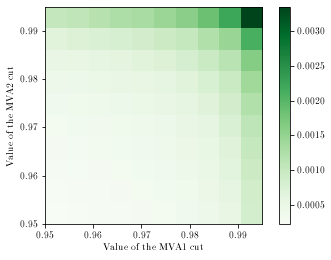

In [8]:
plt.figure()
plt.imshow(p_tab, cmap='Greens',extent=(cut_1[0], cut_1[-1], cut_2[0], cut_2[-1]),origin='lower') #(vmin=0, vmax=0.01)
plt.xlabel('Value of the MVA1 cut')
plt.ylabel('Value of the MVA2 cut')
#plt.xlim(0.99,1)
#plt.ylim(0.99,1)
#plt.title(r'$B_c^+ \rightarrow \tau^+ \nu_\tau$, $B^+ \rightarrow \tau^+ \nu_\tau$ bkg and inclusive $b\bar{b}$ bkg')
plt.colorbar()
plt.show()

In [ ]:
p_tab

In [ ]:
plt.figure()
plt.imshow(np.log(p_tab), cmap='Greens',extent=(cut_1[0], cut_1[-1], cut_2[0], cut_2[-1]),origin='lower') #(vmin=0, vmax=0.01)
plt.xlabel('Value of the MVA1 cut')
plt.ylabel('Value of the MVA2 cut')
#plt.xlim(0.99,1)
#plt.ylim(0.99,1)
#plt.title(r'$B_c^+ \rightarrow \tau^+ \nu_\tau$, $B^+ \rightarrow \tau^+ \nu_\tau$ bkg and inclusive $b\bar{b}$ bkg')
plt.colorbar()
plt.show()